In [1]:
import os
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.callbacks import TQDMProgressBar

import torch
from torch.utils.data import TensorDataset, DataLoader
from src.model_specpred import SpectrumPredictor
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)

/global/homes/z/zhantao/.conda/envs/sqt/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = torch.load("data/CrI3/20221110.pt")
X = data['param'][:,:2]
Y = torch.cat((data['omega'], data['inten']), dim=1)
indices = np.arange(X.shape[0])

rdn_state = 42
X_train, X_val_test, Y_train, Y_val_test, indices_train, indices_val_test = train_test_split(X, Y, indices, test_size=2/10, random_state=rdn_state)
X_val, X_test, Y_val, Y_test, indices_val, indices_test = train_test_split(X_val_test, Y_val_test, indices_val_test, test_size=1/2, random_state=rdn_state)

assert torch.all(torch.tensor([eval(f"torch.all(X_{s} == X[indices_{s}])") for s in ['train', 'val', 'test']]))
indices_fname = f"data_splitting/indices_{rdn_state}_{len(indices_train)}-{len(indices_val)}-{len(indices_test)}.pt"
if not os.path.isfile(indices_fname):
    print("saving to ", indices_fname)
    torch.save({"train": indices_train, "val": indices_val, "test": indices_test}, indices_fname)
else:
    print("indices file already exists")

print("print some values for further reference:")
print("training:\n", X_train[:5])
print("validation:\n", X_val[:5])
print("testing:\n", X_test[:5])

train_dataset = TensorDataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = TensorDataset(X_val, Y_val)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

indices file already exists
print some values for further reference:
training:
 tensor([[-2.3143, -0.3618],
        [-2.4444, -0.6381],
        [-2.6286, -0.5272],
        [-1.8786, -0.7309],
        [-2.6962, -0.1298]])
validation:
 tensor([[-2.3239, -0.7632],
        [-2.5760, -0.7125],
        [-1.5439, -0.2241],
        [-1.0737, -0.6450],
        [-1.4596, -0.8546]])
testing:
 tensor([[-1.5924e+00, -2.1911e-01],
        [-2.9503e+00, -8.5994e-04],
        [-1.6105e+00, -2.4190e-01],
        [-2.3308e+00, -4.2538e-01],
        [-1.8445e+00, -5.6670e-01]])


In [3]:
model_spec = SpectrumPredictor(num_param_in=X.shape[1], num_mode=2)

In [4]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    save_on_train_epoch_end=True, save_last=True, save_top_k=1, monitor="val_loss"
)

trainer = pl.Trainer(
    max_epochs=10000, accelerator="gpu",
    callbacks=[checkpoint_callback, TQDMProgressBar(refresh_rate=5)],
    log_every_n_steps=2, devices=1, 
    enable_checkpointing=True,
    default_root_dir="training_logs"
    )

trainer.fit(model_spec, train_dataloader, val_dataloader)

/global/homes/z/zhantao/.conda/envs/sqt/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /global/homes/z/zhantao/.conda/envs/sqt/lib/python3. ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
---------------

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/global/homes/z/zhantao/.conda/envs/sqt/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/global/homes/z/zhantao/.conda/envs/sqt/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9999: 100%|██████████| 57/57 [00:00<00:00, 352.27it/s, loss=0.000152, v_num=6]

`Trainer.fit` stopped: `max_epochs=10000` reached.


Epoch 9999: 100%|██████████| 57/57 [00:00<00:00, 340.94it/s, loss=0.000152, v_num=6]


In [5]:
model_spec.load_from_checkpoint("training_logs/lightning_logs/version_6/checkpoints/epoch=8456-step=422850.ckpt")

SpectrumPredictor(
  (fc_net): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=4, bias=False)
  )
)

In [6]:
Y_val_pred = []
with torch.no_grad():
    for x_val in X_val:
        Y_val_pred.append(model_spec(x_val.to(model_spec.device)).detach())
Y_val_pred = torch.vstack(Y_val_pred).cpu()

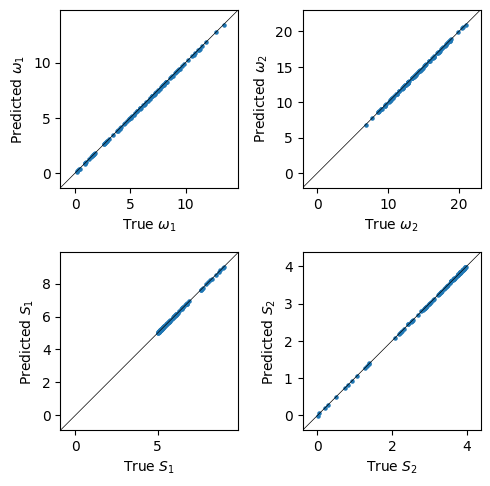

In [7]:
labels = ['$\omega_1$', '$\omega_2$', '$S_1$', '$S_2$']

fig = plt.figure(figsize=(5,5))
gs = plt.GridSpec(2,2)
for i in range(4):
    ax = fig.add_subplot(gs[i])
    ax.plot([-100,100], [-100,100], 'k', linewidth=0.5)
    ax.scatter(Y_val[:,i], Y_val_pred[:,i], s=5)
    ax.set_aspect('equal')
    ax.set_xlim([-0.1*Y_val[:,i].max(), 1.1*Y_val[:,i].max()])
    ax.set_ylim([-0.1*Y_val[:,i].max(), 1.1*Y_val[:,i].max()])
    ax.set_xlabel(f"True {labels[i]}")
    ax.set_ylabel(f"Predicted {labels[i]}")

fig.tight_layout()